<div style="background: navy; color: white; padding: 20px">

# $\S 4.7$: A non-Markovian detection example.
### Z Issa June 2023

In this notebook, we give details of an experiment which is able to handle non-Markovian data, without violating any assumptions associated to the MMD two sample test.

### Background.

Let $(\Omega, \mathcal{F}, (\mathcal{F}_t), \mathbb{P})$ be a filtered probabiltiy space. Suppose we have a stochastic process $S \in C(I, \mathbb{R}^d)$ where $I = [0, T]$ for $T > 0$. In our setting, $S_t$ will be the linear interpolant of a discretely-observed process $\hat{\mathsf{s}} = (s_1, \dots, s_N)$, where $s_{t_i} \sim S_{t_i}$ for some $N \in \mathbb{N}$, but it will be relevant to consider the ``generating'' process. We will assume that $S$ is a continuous semimartingale.

The general problem we are interested in is detecting when we have seen a change in ``regime'', that is, a measurable, consistent change in the dynamics of $S$. In a synthetic example, if $S$ is the solution to a stochastic differential equation (SDE) with parameters $\theta_1$, a regime change would represent a change in parameters from $\theta_1$ to some $\theta_2$. In theory $S$ is no longer the same stochastic process (it is now associated to a different strong solution), but since an observer is unaware of these latent state shifts the process remains the same.

The (naive) idea used to tackle this regime-shifting problem is to use the maximum mean discrepancy associated to the rank-$r$ siganture kernel $\mathcal{D}^r_{\text{sig}}$. For a vector of hyperparameters $h= (h_1, h_2)$ we create a set of (progressive, non-overlapping) sub-paths of length $h_1$ extracted from $\hat{\mathsf{s}}$, denoted $\mathcal{SP}_h(\hat{\mathsf{s}})$. We can then amalgamate these into ensembles; call this set $\mathcal{EP}_h(\hat{\mathsf{s}})$. The regime detection problem is now about finding path ensembles to compare to elements of $\mathcal{EP}_h(\hat{\mathsf{s}})$. This can be done with <i>belief</i>, which can be either parametric, i.e., a pre-generated bank(s) of paths from a parametrized model, or non-parametric, i.e. paths sampled from the data distribution. One can then employ a two-sample testing procedure between one's beliefs and the set $\mathcal{EP}_h(\hat{\mathsf{s}})$ to determine when parameters change to $\theta_2$ from $\theta_1$.

### Two-sample testing

For the two-sample testing procedure to work between empirical samples $X = (x_1, \dots, x_N)$ and $Y=  (y_1, \dots, y_M)$, there are two fundamental assumptions: 1) each $x_i, y_j$ is independent and 2) identically distributed. Returning to the path partitioning problem: we can represent the set $\mathcal{EP}_h(\hat{\mathsf{s}})$ as a sequence of random variables, given we know the generating model $S$:

\begin{equation*}
    \mathcal{EP}_h(\hat{\mathsf{s}}) = \{ s|_{[u_i, v_i]} : |v_i - u_i| = h_1, v_{i} = u_{i+1} \text{ for } i = 1,\dots, N_1, s_{t_i} \sim S_{t_i}\},
\end{equation*}

where $N_1$ is the total number of sub-paths able to be extracted from $\hat{\mathsf{s}}$, given $h$. Now, again the elements of $\mathcal{EP}_h(\hat{\mathsf{s}})$ are piecewise-linear interpolants (approximations) of the true objects, but for now we work with the continuous-time objects for ease of notation. Now, we can explicitly write the distribution of each $S|_{[u_i, v_i]}$. It is given by

\begin{equation*}
    s|_{[u_i, v_i]} \sim \mathbb{P}(S|_{[u_i, v_i]} | \mathcal{F}_{u_i}) \text{ for }i=1,\dots, N_1,
\end{equation*}

so clearly assumption 2) is violated in the general case! In particular, beliefs are always simulated distributed according to the initial data, and by construction do not include the history of the path.

If $S$ is Markovian, then both assumptions 1) and 2) will hold, after normalizing for the initial data. In a non-Markovian setting, though, this cannot be the case.

### A modificaiton: using the signature similarity score $\Sigma^{\mathbb{P}, \mathbb{Q}}$

Recall that the conformance scoring function $\Sigma^{\mathbb{P}, \mathbb{Q}}(s)$ gives the conformance of the path $s$ relative to the two measures $\mathbb{P}, \mathbb{Q}$. Suppose $s \sim \mathbb{P}(S|_{u, v} | \mathcal{F}_u)$. Then, we can set our beliefs to be progressively enlarging sets of paths over $[0, T]$, and study the whole history of $s$ instead of just the path segment itself. Or, we can sample path segments from our beliefs that have been generated up until $u$, at least.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from higherOrderKME import sigkernel
from tqdm.notebook import tqdm

from src.generators.config import ModelConfig
from src.testing import TestConfig
from src.testing.experiment_functions.mmd_test_functions import get_beliefs_from_config
from src.testing.experiment_functions.plot_result_functions import plot_path_experiment_result, plot_path_test_threshold
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.auxiliary_classes.RegimePartitioner import RegimePartitionerConfig, RegimePartitioner
from src.utils.helper_functions.plot_helper_functions import plot_regime_change_path
from src.utils.helper_functions.test_helper_functions import get_sub_paths

np.random.seed(1)
matplotlib.rc_file_defaults()

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<div style="background: navy; color: white; padding: 20px">


## 1. Configurations

In the first experiment, we try to detect whether a path is exhibiting memory (non-Markovianity) or no memory. This will be a regime-switching problem where the first model is taken to be a gBm, and the second to be a rBergomi.

In [3]:
# Set configs
test_config             = TestConfig()
model_config            = ModelConfig()

model_config.override_args({
    "year_mesh": 7*252,
    "attach_volatility": False
})


T   = 4                         # Time to simulate regime-changed path until
dim = 2                         # Dimensionality of simulated paths 
S0  = [1. for _ in range(dim)]  # Initial value of simulated paths
dt  = 1/model_config.year_mesh  # Size of path increment
 
gbm_params_h0 = [0, 0.2]
gbm_params_h1 = [0, 0.25]
rB_params_h0  = [0.05, 0.05, -0.7, 0.4]
rB_params_h1  = [0.03, 0.5, -0.7, 0.2]

model_names = ["rBergomi", "gbm"]
model_params = [[rB_params_h0 for _ in range(dim)], [gbm_params_h1 for _ in range(dim)]]

test_config.override_args({
    "n_steps": T*model_config.year_mesh,
    "n_paths": 8,
    "offset" : 0,
    "weight_factor": 1,
    "belief_models": model_names,
    "model_pair_names": model_names,
    "belief_params": model_params,
    "model_pair_params": model_params,
    "path_bank_size": 10000
})

In [4]:
# Generate beliefs (P and Q)
beliefs, belief_details, model_pairs = get_beliefs_from_config(test_config, model_config, overwrite=False)

100%|██████████| 10000/10000 [00:13<00:00, 720.78it/s]


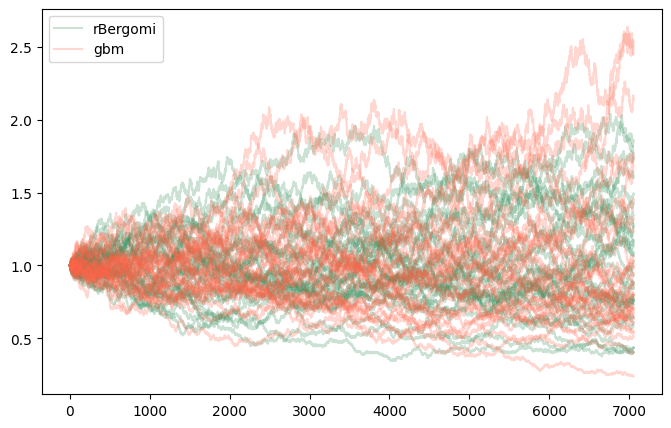

In [5]:
# Plot some examples
n_plot_samples = 32
cols = ["seagreen", "tomato"]
labels = model_names

fig, ax = plt.subplots(figsize=(8, 5))

for i, bank in enumerate(beliefs):
    for j, p in enumerate(bank[:n_plot_samples]):
        label = labels[i] if j == 0 else ""
        ax.plot(p[:, 1], color=cols[i], alpha=0.25, label=label)
ax.legend();

<div style="background: navy; color: white; padding: 20px">

## 2. Initialize detector

We use the rank-$r$ signature kernel MMD.


In [6]:
def wrapper(paths: iter) -> torch.tensor:
    """
    Wraps a numpy array around a PyTorch tensor, to compute the MMD using the SigKernel package.

    :param paths:   Array. Path to be wrapped.
    :return:        Torch tensor initialised on the GPU
    """

    return torch.tensor(paths, dtype=torch.float64, device=device)

def set_scoring_rule(signature_kernel, order, lambd_=1e-5):
    def scoring_rule(X, y):
        X = wrapper(X)
        y = wrapper(y)
        
        if order == 1:
            K_XX = signature_kernel.compute_Gram(X, X, sym=True)
            K_Xy = signature_kernel.compute_Gram(X, y, sym=False)
        elif order == 2:
            K_XX_1 = signature_kernel.compute_Gram(X, X, sym=True, return_sol_grid=True)
            K_Xy_1 = signature_kernel.compute_Gram(X, y, sym=False, return_sol_grid=True)
            K_yy_1 = signature_kernel.compute_Gram(y, y, sym=True, return_sol_grid=True)
            
            K_XX = signature_kernel.compute_HigherOrder_Gram(K_XX_1, K_XX_1, K_XX_1, lambd_, sym=True)
            K_Xy = signature_kernel.compute_HigherOrder_Gram(K_XX_1, K_Xy_1, K_yy_1, lambd_, sym=False)
            
        K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
        
        return K_XX_m - 2. * torch.mean(K_Xy)
    
    return scoring_rule

def set_conformance_score(X, Y, scoring_rule):
    def conformance_score(x):
        return scoring_rule(X, x) - scoring_rule(Y, x)
    return conformance_score

In [7]:
sigma1 = 1e0
sigma2 = 7.5e2

dyadic_order_1 = 1
dyadic_order_2 = 1

lambd_ = 1e-5

static_kernel_1 = sigkernel.RBFKernel(sigma=sigma1)
static_kernel_2 = sigkernel.RBFKernel(sigma=sigma2)

sigker_rank_1 = sigkernel.SigKernel(static_kernel = static_kernel_1, dyadic_order=dyadic_order_1)
sigker_rank_2 = sigkernel.SigKernel(static_kernel=[static_kernel_1, static_kernel_2], dyadic_order=[dyadic_order_1, dyadic_order_2])

scoring_rule_rank_1 = set_scoring_rule(sigker_rank_1, 1)
scoring_rule_rank_2 = set_scoring_rule(sigker_rank_2, 2, lambd_=lambd_)

P, Q = beliefs

<div style="background: navy; color: white; padding: 20px">


## 3. Build regime-changed path and plot

In [8]:
regime_config   = RegimePartitionerConfig()

regime_config.override_args({
    "n_regime_changes": 5,
    "f_length_scale"  : 0.5, 
    "type"            : "random_on_off_steps", 
    "r_on_args"       : ["poisson", 1],
    "r_off_args"      : ["poisson", 1/128],
    "r_min_distance"  : 16,
    "r_min_gap"       : 16
})

In [9]:
# Generate path for testing
np.random.seed(1)

regime_partitioner = RegimePartitioner(model_config.year_mesh, regime_config)

total_steps = T*model_config.year_mesh
midpt       = int(total_steps/2)

regime_partitioner.normal_regimes = [[0, midpt]]
regime_partitioner.regime_changes  = [[midpt+1, total_steps]]
regime_partitioner.time_indexes   = [[0, midpt], [midpt+1, total_steps]]

test_path = regime_partitioner.generate_regime_change_path(model_pairs, S0)

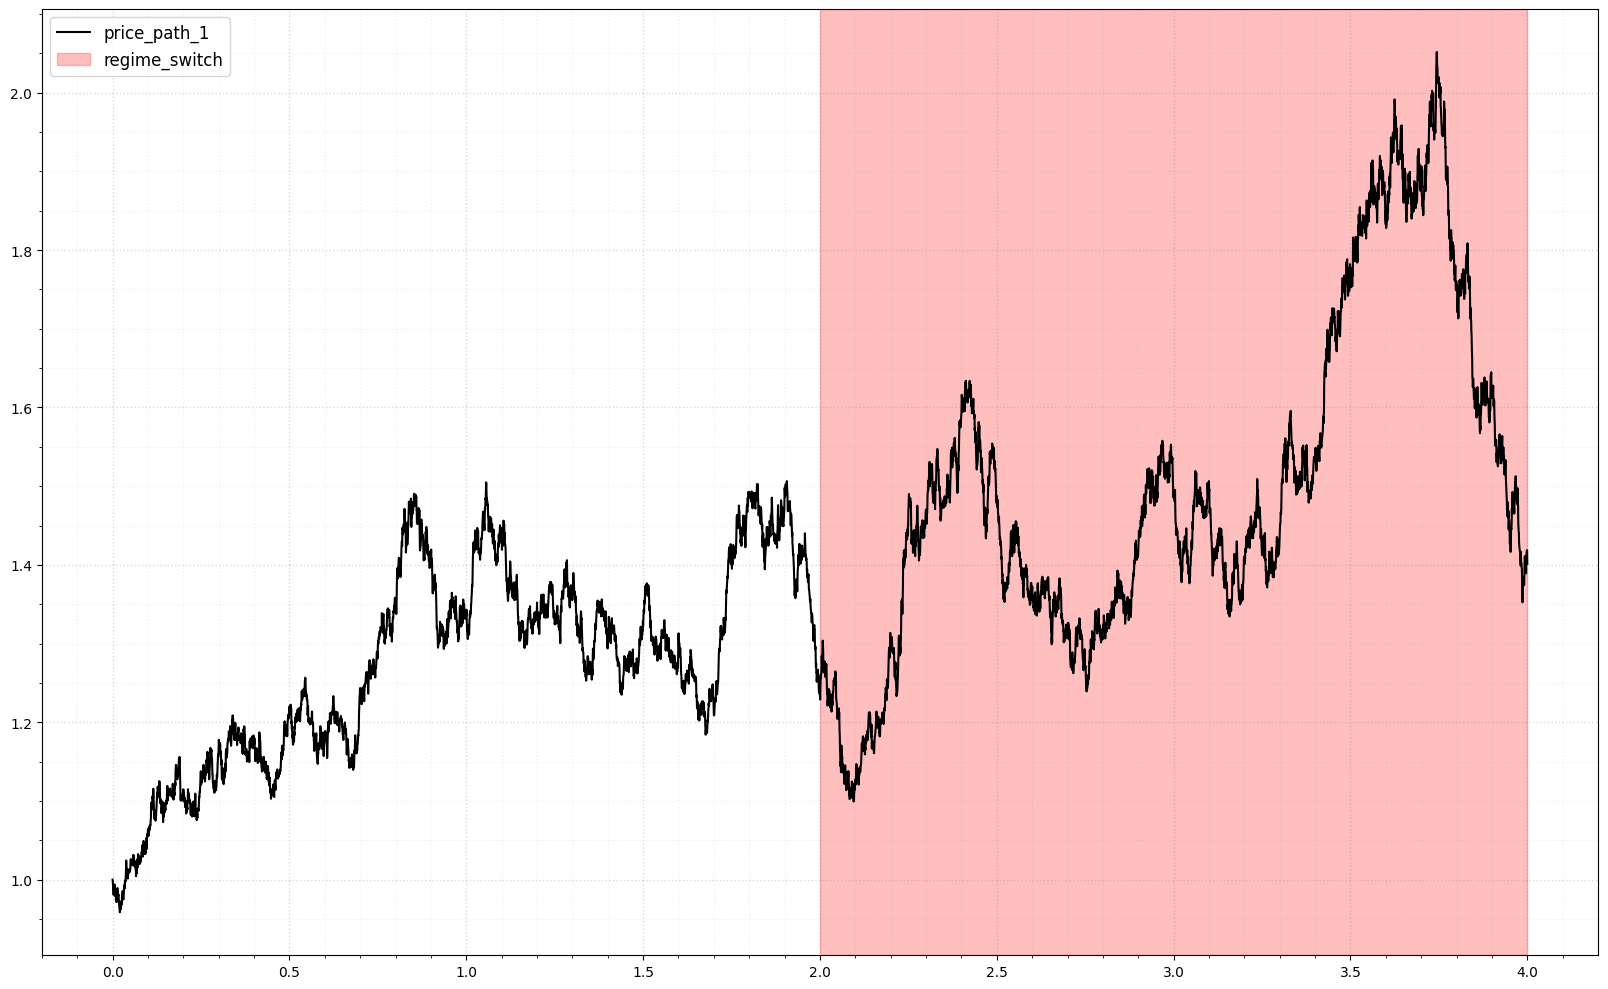

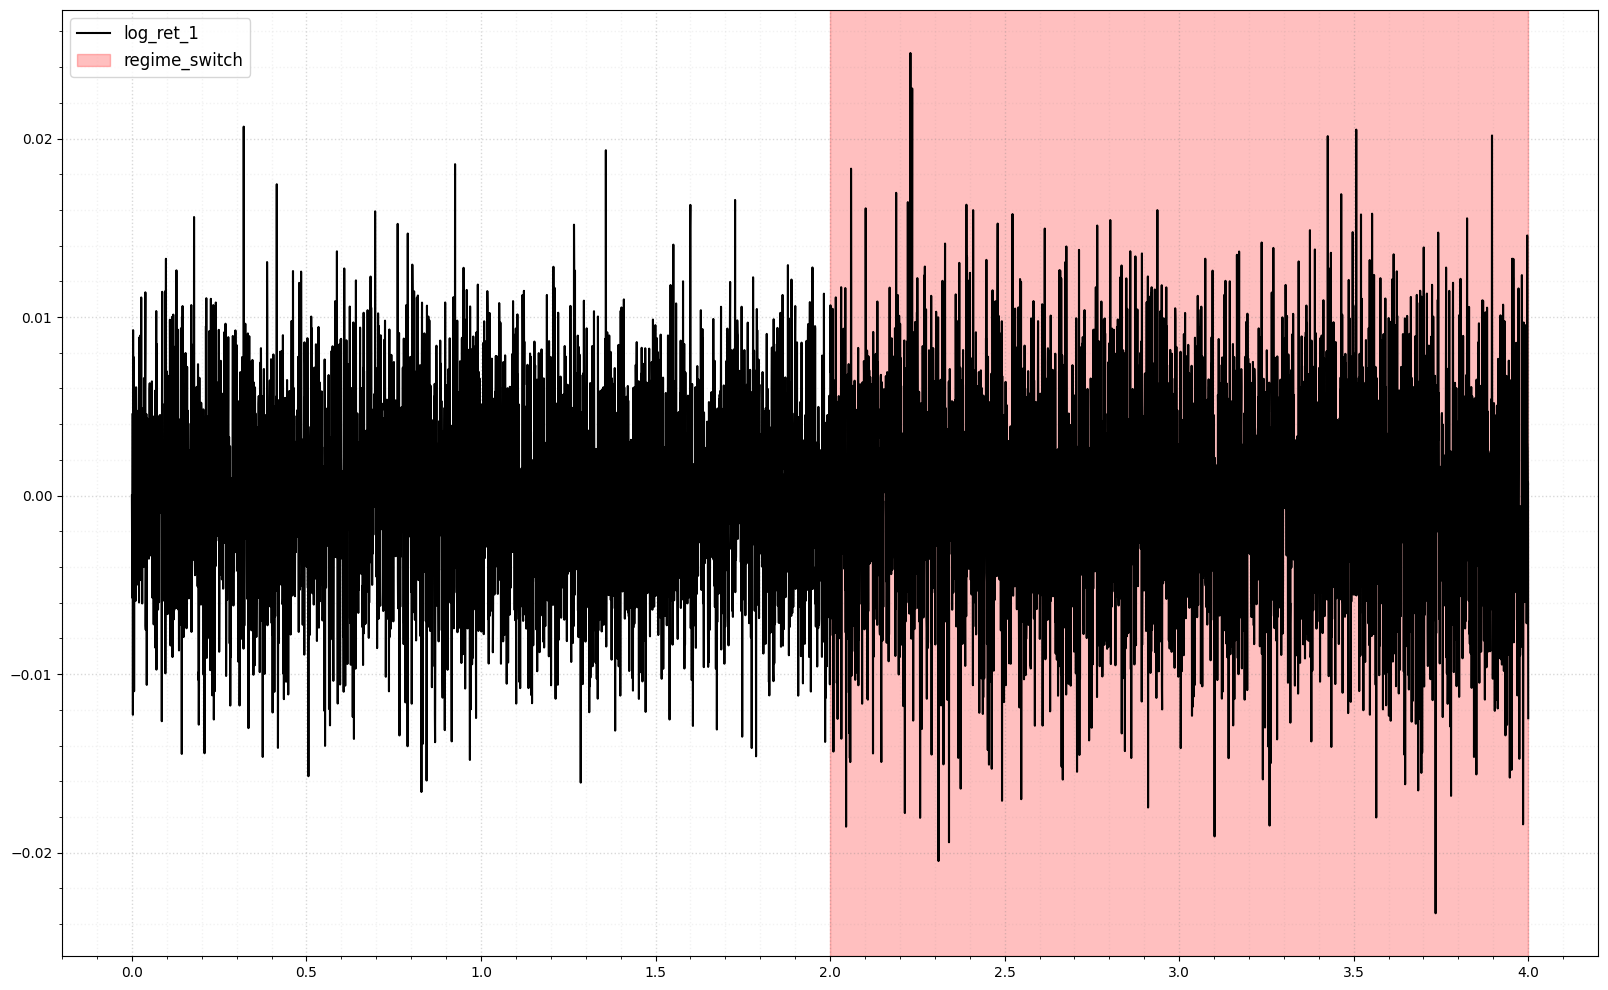

In [10]:
_, regime_changes, _ = regime_partitioner.changes_to_times()
path_splits_time = [item for sublist in [[r[0], r[1] + 1/model_config.year_mesh] for r in regime_changes] for item in sublist] 
path_splits_mesh = [int(p*model_config.year_mesh) for p in path_splits_time]

plot_regime_change_path(test_path, regime_changes, log_returns=False, one_dim=True)
plot_regime_change_path(test_path, regime_changes, log_returns=True, one_dim=True)

<div style="background: navy; color: white; padding: 20px">

## 4. Study: 2 types of experiments


Given increment level $h_1 \in \mathbb{N}$, we consider two of the following:

1) Studying $\hat{\mathsf{s}}_{[0, t]} | \mathcal{F}_t$ against samples $\hat{\mathsf{x}}_{[0, t]}\sim \mathbb{P}_i(\cdot | \mathcal{F}_t)$, where each $\hat{\mathsf{x}} \in \mathfrak{P}_i$ for $i=1,2$, or
2) Studying $\hat{\mathsf{s}}_{[t-h_, t]} | \mathcal{F}_t$ against samples in the same way. Here, we do not take the whole path (both the regime-changed and the belief paths) but just a small, windowed sample from it. Important here to not actually normalize the path - or the time channels - taking the time difference transform may be appropriate here.

In each case, we will study what happens around the regime change event. With the conformance score $\Sigma^{\mathbb{P}, \mathbb{Q}}(x) = s(\mathbb{P}, x) - s(\mathbb{Q}, x)$, we should expect the score to be negative during the first regime, then shift to positive during the second.

We will evaluate the results using both the rank-1 and rank-2 MMD.

In [11]:
path_transformer_config = PathTransformerConfig()

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True , 0, {"s_type": "initial"}),
    "time_normalisation_transform":  (False , 0, {}),
    "time_difference_transform":     (False, 0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (True, 0, {"all_channels": True}), 
    "scaling_transform":             (False, 0, {"sigmas": [(1/dt)**0.6 for _ in range(dim)]}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})


path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8
path_transformer = PathTransformer(path_transformer_config)

In [12]:
# First experiment: progressively evaluate path, study score at regime change event 
n_eval_steps = 32   # Number of steps to take before making path evaluation
emp_size     = 128  # Size of empirical distributions used to estimate P and Q

metrics = [scoring_rule_rank_1]#, scoring_rule_rank_2]
pb_size = test_config.path_bank_size

# Progressively enlarged path. Calculate score over it 
length, _ = test_path.shape
scores    = torch.zeros((len(metrics), int(length/n_eval_steps), 2))

sub_paths   = get_sub_paths(test_path, n_eval_steps, 0)
n_sub_paths = sub_paths.shape[0]

In [13]:
scores[..., 0] = torch.tensor(sub_paths[:, -1, 0])

for i, sub_path in enumerate(tqdm(sub_paths)):
    
    # Transform sub-paths
    x = path_transformer.transform_paths(np.expand_dims(sub_path, 0), verbose=False)
    
    # Sample from beliefs 
    rand_X = torch.randperm(pb_size)[:emp_size]
    rand_Y = torch.randperm(pb_size)[:emp_size]
    
    st_ind  = int(i*n_eval_steps)
    end_ind = st_ind + n_eval_steps
    
    t_X = path_transformer.transform_paths(P[rand_X, st_ind:end_ind].copy(), verbose=False)
    t_Y = path_transformer.transform_paths(Q[rand_Y, st_ind:end_ind].copy(), verbose=False)
    
    for j, metric in enumerate(metrics):
        conformance     = set_conformance_score(t_X, t_Y, metric)
        scores[j, i, 1] = conformance(x)

  0%|          | 0/220 [00:00<?, ?it/s]

<div style="background: navy; color: white; padding: 20px">

## 5. Calculate and plot results

In [14]:
def calculate_scores(scores_, T, c_alpha, label="mmd1"):
    regime_on_accuracy = torch.mean((scores_[scores_[:, 0] < int(T/2), 1] < c_alpha).type(torch.float64))
    regime_off_accuracy = torch.mean((scores_[scores_[:, 0] > int(T/2), 1] > c_alpha).type(torch.float64))
    total_accuracy = regime_on_accuracy/2 + regime_off_accuracy/2
    
    print(f"{label}:")
    print(f"Regime on accuracy: {100*regime_on_accuracy:.4f}%")
    print(f"Regime off accuracy: {100*regime_off_accuracy:.4f}%")
    print(f"Total accuracy: {100*total_accuracy:.4f}%\n")
    
    return regime_on_accuracy, regime_off_accuracy, total_accuracy

In [15]:
c_alpha = 0
labels = ["mmd1", "mmd2"]
mmd1_alpha_scores = scores[0, :, 1] > c_alpha

if len(metrics) > 1:
    mmd2_alpha_scores = scores[1, :, 1] > c_alpha

for i, _ in enumerate(metrics):
    _ = calculate_scores(scores[i], T, c_alpha, labels[i])


mmd1:
Regime on accuracy: 79.0909%
Regime off accuracy: 74.5455%
Total accuracy: 76.8182%



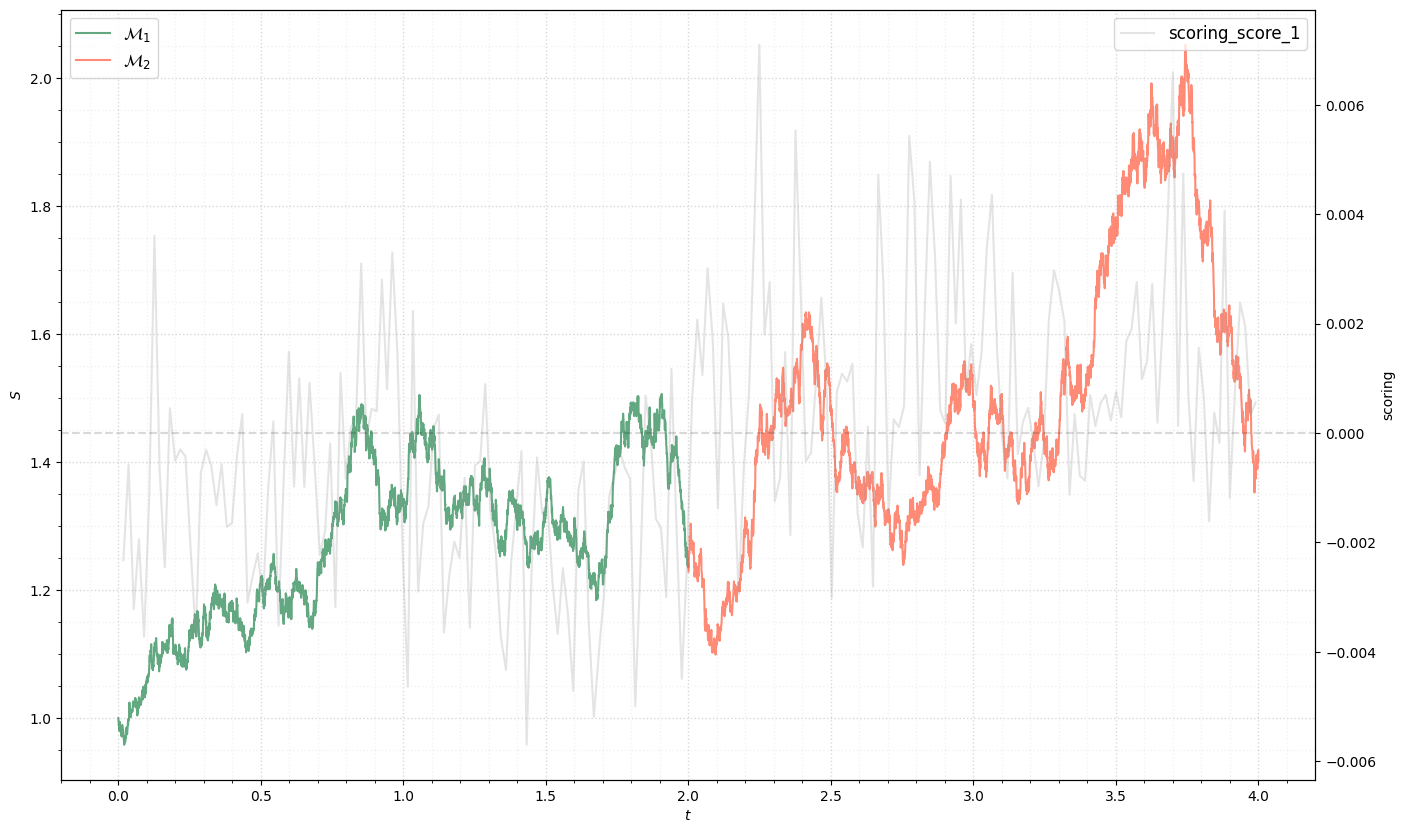

In [16]:
index = scores[0, :, 0]
this_score_array = np.vstack([index, scores[0, :, 1]])

plot_path_experiment_result(test_path, this_score_array, path_splits_mesh, diff=False, zero_bnd=True, y_label="scoring")

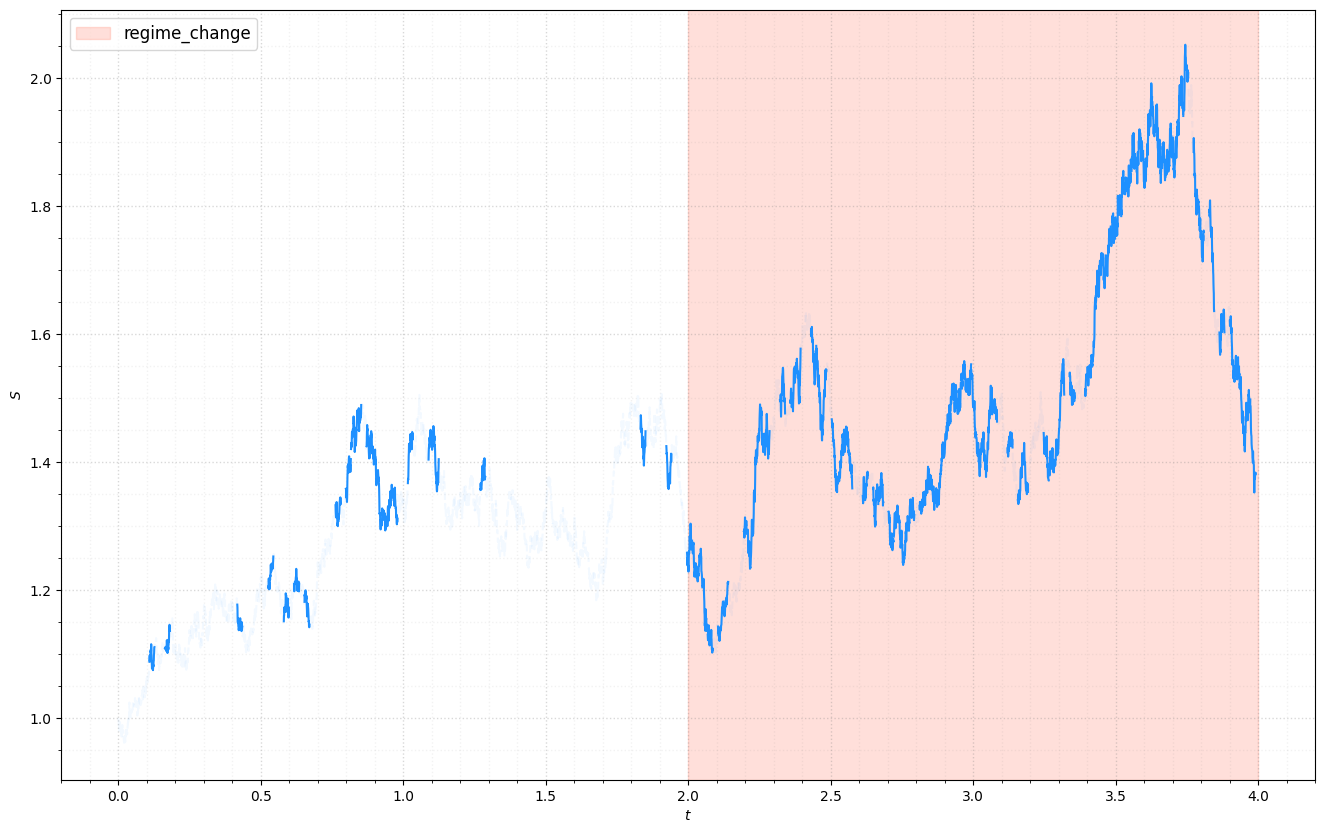

In [17]:
alphas = (scores[0, :, 1] > c_alpha).type(torch.float64).numpy()
plot_path_test_threshold(sub_paths, alphas, path_splits_time, one_dim=True)